In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box, Point, LineString
import rasterio
from rasterio.plot import show
import glob
import os
import fiona

### Area of Interest

In [2]:
# Define the area of interest
place_name = "London, United Kingdom"

# Get the boundary polygon of the area
gdf = ox.geocode_to_gdf(place_name)

# Ensure the CRS is set to WGS84 (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Get the bounding box coordinates
minx, miny, maxx, maxy = gdf.total_bounds

print(f"Bounding Box Coordinates for London:\n"
      f"Min Longitude: {minx}\n"
      f"Min Latitude: {miny}\n"
      f"Max Longitude: {maxx}\n"
      f"Max Latitude: {maxy}")

Bounding Box Coordinates for London:
Min Longitude: -0.5103751
Min Latitude: 51.2867601
Max Longitude: 0.3340155
Max Latitude: 51.6918741


#### London LandUse

In [3]:
# Define the path to the directory containing the shapefile components
file_path = r"C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\londonlanduse\londonlanduse"

# Load the shapefile
landuse_gdf = gpd.read_file(file_path)

# Print the first few rows to verify it loaded correctly
landuse_gdf.head()

,high_level,landuse_de,geometry
0,Water,Coastal water,"POLYGON ((553140.000 175520.000, 553140.000 17..."
1,Man Made,Industrial areas,"POLYGON ((551530.000 177040.000, 551530.000 17..."
2,Managed,Recreational land,"POLYGON ((552300.000 177010.000, 552300.000 17..."
3,Man Made,High density residential with retail and comme...,"POLYGON ((551710.000 177060.000, 551710.000 17..."
4,Natural,Deciduous woodland,"POLYGON ((551370.000 177140.000, 551370.000 17..."


In [4]:
landuse_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 41483 entries, 0 to 41482
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   high_level  41483 non-null  object  
 1   landuse_de  41483 non-null  object  
 2   geometry    41483 non-null  geometry
dtypes: geometry(1), object(2)
memory usage: 972.4+ KB


In [5]:
landuse_gdf['landuse_de'].unique()

array(['Coastal water', 'Industrial areas', 'Recreational land',
       'High density residential with retail and commercial sites',
       'Deciduous woodland',
       'Low density residential with amenities (suburbs and small villages / hamlets)',
       'Medium density residential with high streets and amenities',
       'Large complex buildings various use (travel/recreation/ retail)',
       'Urban centres - mainly commercial/retail with residential pockets',
       'Retail parks', 'Mining and spoil areas', 'Coastal dunes', 'Farms',
       'Inland Water', 'Agriculture - mainly crops',
       'Principle Transport', 'Open or heath and moor land',
       'Agriculture - mixed use', 'Wetlands',
       'Coniferous and undifferentiated woodland', 'Orchards',
       'Glasshouses', 'Business parks'], dtype=object)

In [42]:
landuse_gdf.geometry.type.value_counts()

Polygon         41114
MultiPolygon      369
Name: count, dtype: int64

### Britain Grid Info

In [6]:
# Path to the shapefile directory
britain_grid_path = r"C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\Great_Britain_GRID_shapefile\Great_Britain_GRID_shapefile"

# Load the shapefile into a GeoDataFrame
britain_grid_gdf = gpd.read_file(britain_grid_path)

# Display the first few rows of the GeoDataFrame
britain_grid_gdf.head()

,CELLCODE,EOFORIGIN,NOFORIGIN,geometry
0,100kmE27N29,2700000,2900000,"POLYGON ((2700000.000 2900000.000, 2700000.000..."
1,100kmE27N30,2700000,3000000,"POLYGON ((2700000.000 3000000.000, 2700000.000..."
2,100kmE28N28,2800000,2800000,"POLYGON ((2800000.000 2800000.000, 2800000.000..."
3,100kmE28N29,2800000,2900000,"POLYGON ((2800000.000 2900000.000, 2800000.000..."
4,100kmE28N30,2800000,3000000,"POLYGON ((2800000.000 3000000.000, 2800000.000..."


In [7]:
britain_grid_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CELLCODE   144 non-null    object  
 1   EOFORIGIN  144 non-null    int64   
 2   NOFORIGIN  144 non-null    int64   
 3   geometry   144 non-null    geometry
dtypes: geometry(1), int64(2), object(1)
memory usage: 4.6+ KB


In [43]:
britain_grid_gdf.geometry.type.value_counts()

Polygon    144
Name: count, dtype: int64

###### Filter the Grid Using the Bounding Box

In [8]:
# Transform the CRS of britain_grid_gdf to EPSG:4326
britain_grid_gdf = britain_grid_gdf.to_crs(epsg=4326)

# Create the bounding box geometry using shapely
bounding_box = gpd.GeoDataFrame(index=[0], geometry=[box(minx, miny, maxx, maxy)], crs="EPSG:4326")

# Filter the grid based on the bounding box coordinates
london_grid_gdf = britain_grid_gdf[britain_grid_gdf.geometry.intersects(bounding_box.iloc[0].geometry)]

# Display the rows of the filtered GeoDataFrame
london_grid_gdf

,CELLCODE,EOFORIGIN,NOFORIGIN,geometry
82,100kmE35N31,3500000,3100000,"POLYGON ((-1.60847 50.42480, -1.83395 51.31044..."
83,100kmE35N32,3500000,3200000,"POLYGON ((-1.83395 51.31044, -2.07046 52.19528..."
96,100kmE36N31,3600000,3100000,"POLYGON ((-0.21230 50.55834, -0.41166 51.44694..."
97,100kmE36N32,3600000,3200000,"POLYGON ((-0.41166 51.44694, -0.62083 52.33489..."


In [9]:
london_grid_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4 entries, 82 to 97
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CELLCODE   4 non-null      object  
 1   EOFORIGIN  4 non-null      int64   
 2   NOFORIGIN  4 non-null      int64   
 3   geometry   4 non-null      geometry
dtypes: geometry(1), int64(2), object(1)
memory usage: 160.0+ bytes


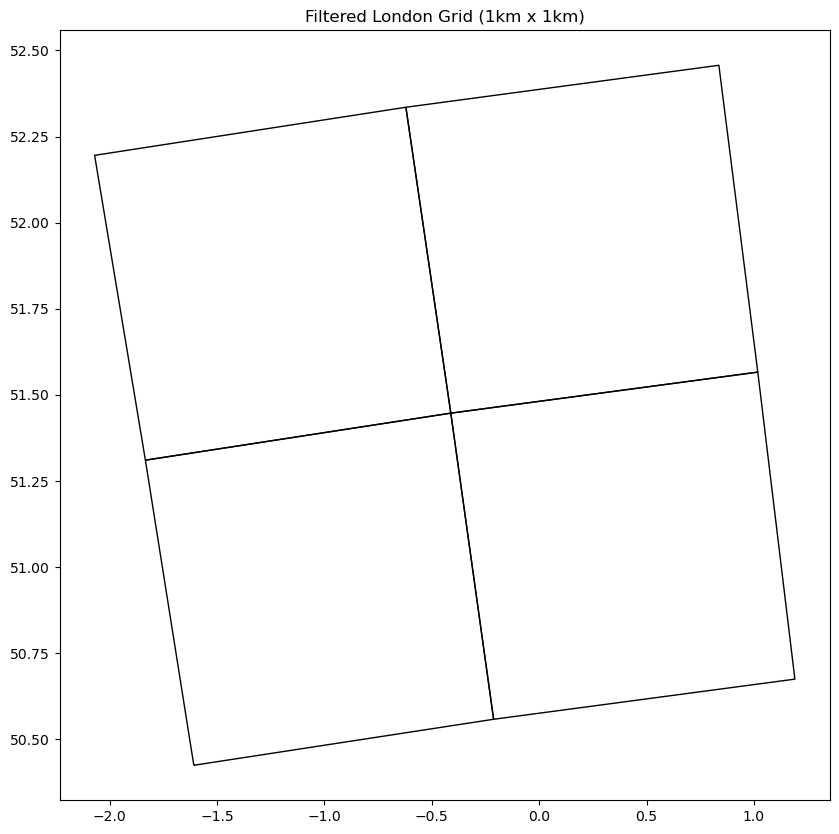

In [10]:
# Plot the filtered grid to verify
fig, ax = plt.subplots(figsize=(10, 10))
london_grid_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
plt.title('Filtered London Grid (1km x 1km)')
plt.show()

### Point of Interest
it is useful for:


Identifying type and purpose of building


Show range of services available in area

In [11]:
# Path to the GeoPackage file
poi_path = r"C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\poi_5558590\poi_5558590.gpkg"

# Load the GeoPackage file
poi_gdf  = gpd.read_file(poi_path)

# Display the first few rows to verify it loaded correctly
poi_gdf.head()

,ref_no,name,pointx_class,groupname,categoryname,classname,feature_easting,feature_northing,pos_accuracy,uprn,...,postcode,admin_boundary,telephone_number,url,brand,qualifier_type,qualifier_data,provenance,supply_date,geometry
0,17967878,Fountain,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,523926.0,165927.0,2,NaN,...,SM3,Sutton London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (523926.000 165927.000)
1,17969865,Clock Tower,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,529022.0,179133.0,2,NaN,...,SW1E,City of Westminster London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (529022.000 179133.000)
2,17970650,Fountain,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,529233.0,179665.0,2,NaN,...,SW1A,City of Westminster London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (529233.000 179665.000)
3,17970666,Flagstaff,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,529659.0,178834.0,2,NaN,...,SW1P,City of Westminster London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (529659.000 178834.000)
4,17972867,Fountain,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,529966.0,180448.0,2,NaN,...,WC2N,City of Westminster London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2024-06-01,POINT (529966.000 180448.000)


In [12]:
poi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 385401 entries, 0 to 385400
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   ref_no             385401 non-null  int64   
 1   name               385401 non-null  object  
 2   pointx_class       385401 non-null  object  
 3   groupname          385401 non-null  object  
 4   categoryname       385401 non-null  object  
 5   classname          385401 non-null  object  
 6   feature_easting    385401 non-null  float64 
 7   feature_northing   385401 non-null  float64 
 8   pos_accuracy       385401 non-null  int64   
 9   uprn               273226 non-null  float64 
 10  topo_toid          385401 non-null  object  
 11  topo_toid_version  385401 non-null  int64   
 12  usrn               385401 non-null  object  
 13  usrn_mi            385401 non-null  int64   
 14  distance           385401 non-null  float64 
 15  address_detail     281731 

In [13]:
poi_gdf['groupname'].unique()

array(['Attractions', 'Public Infrastructure', 'Education and Health',
       'Commercial Services', 'Manufacturing and Production',
       'Accommodation, Eating and Drinking', 'Transport',
       'Sport and Entertainment', 'Retail'], dtype=object)

### OS Open Built Up Areas 
it is a dataset representing Built Up Areas of Great Britain designed to underpin statistical analysis and contribute to policy enablement across the public sector.

In [14]:
# Path to the GeoPackage file
builtup_file = r"C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\open-built-up-areas_5556544\OS_Open_Built_Up_Areas.gpkg"

# Load the GeoPackage file
builtup_area_gdf = gpd.read_file(builtup_file)

# Display the first few rows to verify it loaded correctly
builtup_area_gdf.head()

,gsscode,name1_text,name1_language,name2_text,name2_language,areahectares,geometry_area_m,geometry
0,E63003246,Abberley,NaN,NaN,NaN,21.44,214375.0,"MULTIPOLYGON (((374400.000 267625.000, 374425...."
1,E63000162,Abbeytown,NaN,NaN,NaN,29.25,292500.0,"MULTIPOLYGON (((317800.000 550950.000, 317800...."
2,E63002230,Abbots Bromley,NaN,NaN,NaN,68.38,683750.0,"MULTIPOLYGON (((407450.000 324925.000, 407475...."
3,E63004551,Abbots Langley and Kings Langley,NaN,NaN,NaN,547.50,5475000.0,"MULTIPOLYGON (((505650.000 202650.000, 505675...."
4,E63005038,Abbots Leigh,NaN,NaN,NaN,54.69,546875.0,"MULTIPOLYGON (((353825.000 173300.000, 353825...."


In [15]:
builtup_area_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8545 entries, 0 to 8544
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   gsscode          8545 non-null   object  
 1   name1_text       8545 non-null   object  
 2   name1_language   210 non-null    object  
 3   name2_text       222 non-null    object  
 4   name2_language   210 non-null    object  
 5   areahectares     8545 non-null   float64 
 6   geometry_area_m  8545 non-null   float64 
 7   geometry         8545 non-null   geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 534.2+ KB


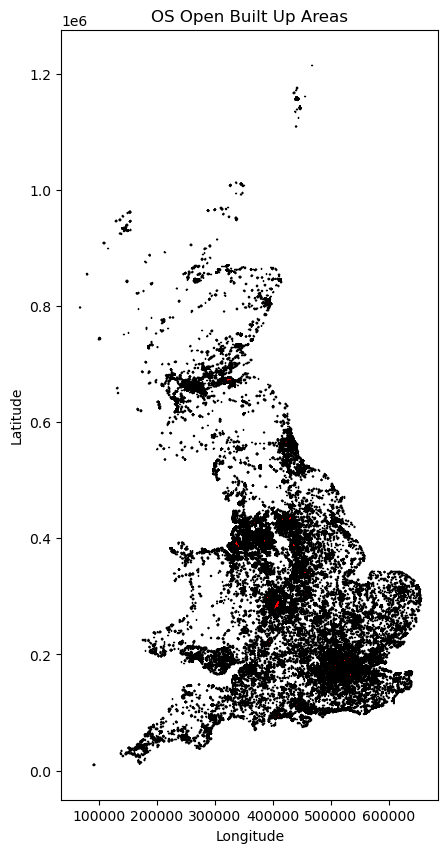

In [16]:
# Plot the data
fig, ax = plt.subplots(figsize=(14, 10))
builtup_area_gdf.plot(ax=ax, color='red', edgecolor='k')
ax.set_title("OS Open Built Up Areas")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

### VectorMap Local 
it is useful for:

Making custom maps showing local detail

Detailed maps in urban areas

In [17]:
# Paths to the VectorMap Local data directories
vml_tl_path = r"C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl"
vml_tq_path = r"C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tq"

# List to hold individual GeoDataFrames
vml_data_list = []

# Function to load all GeoPackage files in a directory
def load_geopackages(directory, data_list):
    for filename in os.listdir(directory):
        if filename.endswith(".gpkg"):
            gpkg_file_path = os.path.join(directory, filename)
            try:
                gpkg_data = gpd.read_file(gpkg_file_path)
                data_list.append(gpkg_data)
                print(f"Loaded: {gpkg_file_path}")
            except Exception as e:
                print(f"Error loading {gpkg_file_path}: {e}")

# Load GeoPackage files from both directories
load_geopackages(vml_tl_path, vml_data_list)
load_geopackages(vml_tq_path, vml_data_list)

# Check if any data was loaded before concatenating
if vml_data_list:
    # Concatenate all GeoDataFrames into a single GeoDataFrame
    vml_gdf = gpd.GeoDataFrame(pd.concat(vml_data_list, ignore_index=True))
    print("All data loaded and concatenated into a single GeoDataFrame.")
else:
    vml_gdf = gpd.GeoDataFrame()
    print("No data loaded. The list is empty.")

Loaded: C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl\vml-tl00se.gpkg
Loaded: C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl\vml-tl00sw.gpkg
Loaded: C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl\vml-tl10se.gpkg
Loaded: C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl\vml-tl10sw.gpkg
Loaded: C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl\vml-tl20se.gpkg
Loaded: C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl\vml-tl20sw.gpkg
Loaded: C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl\vml-tl30se.gpkg
Loaded: C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl\vml-tl30sw.gpkg
Loaded: C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\vml_5558592\tl\vml-tl40

In [18]:
# Display the concatenated GeoDataFrame info
vml_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58738 entries, 0 to 58737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Fid       58738 non-null  object  
 1   FeatCode  58738 non-null  int64   
 2   FeatDesc  58738 non-null  object  
 3   geometry  58738 non-null  geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 1.8+ MB


In [19]:
vml_gdf['FeatDesc'].unique()

array(['Urban Extent', 'Shrub And Marsh',
       'Broad-leafed Woodland And Shrub', 'Reeds', 'Unimproved Grass',
       'Orchard', 'Mixed Woodland', 'Marsh', 'Coniferous Woodland',
       'Shrub And Unimproved Grass', 'Mixed Woodland And Shrub',
       'Broad-leafed Woodland', 'Custom Landform Polygon', 'Shrub',
       'Shrub And Marsh And Unimproved Grass',
       'Coniferous Woodland And Shrub', 'Marsh And Unimproved Grass',
       'Heathland And Unimproved Grass', 'Shrub And Heathland',
       'Heathland', 'Shrub And Heathland And Unimproved Grass', 'Sand',
       'Refuse Or Slag Heap', 'Shingle', 'Inland Rock', 'Mud',
       'Shingle And Mud', 'Shingle And Sand', 'Boulders',
       'Building Polygon', 'Boulders And Mud', 'Boulders And Shingle'],
      dtype=object)

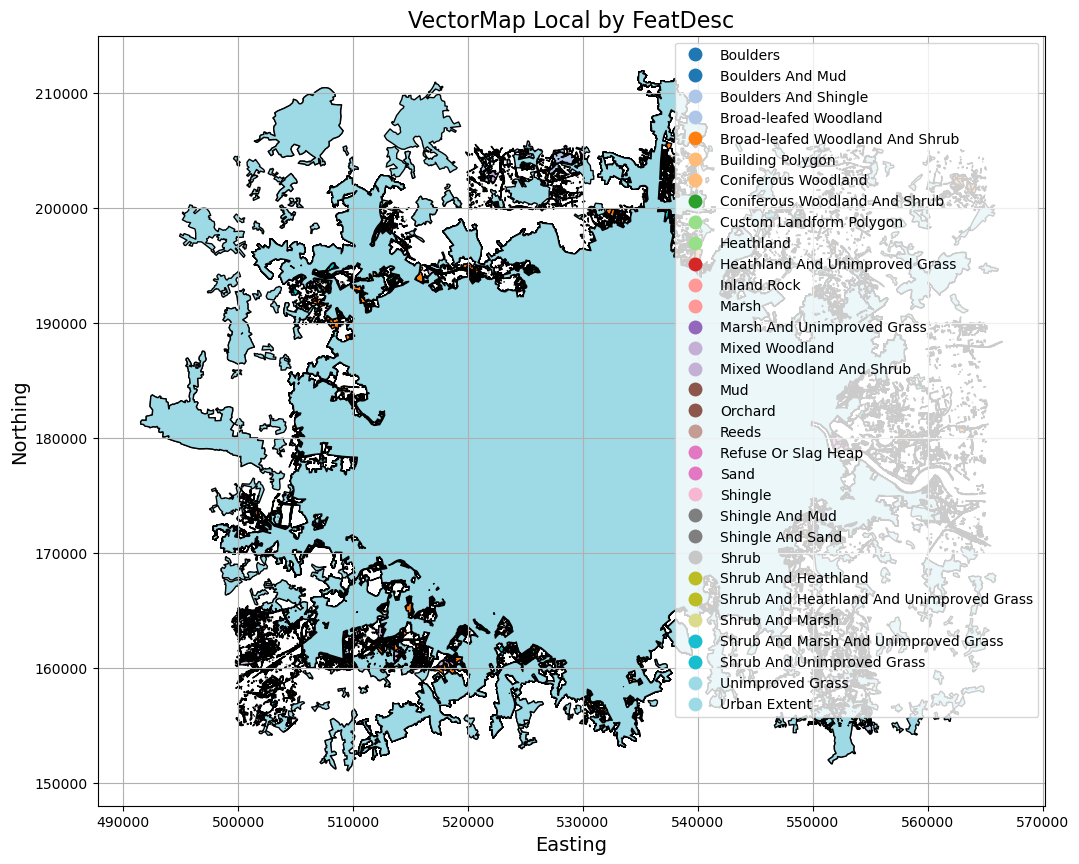

In [20]:
# Plotting based on FeatDesc with improved color scheme
fig2, ax2 = plt.subplots(figsize=(14, 10))

#colormap with more colors
cmap = 'tab20'

# Plot the GeoDataFrame, coloring by 'FeatDesc'
vml_gdf.plot(column='FeatDesc', ax=ax2, legend=True, edgecolor='black', cmap=cmap, markersize=2)

# Customize the plot
ax2.set_title("VectorMap Local by FeatDesc", fontsize=16)
ax2.set_xlabel("Easting", fontsize=14)
ax2.set_ylabel("Northing", fontsize=14)
ax2.grid(True)

# Show the plot
plt.show()

In [44]:
vml_gdf.geometry.type.value_counts()

Polygon    58738
Name: count, dtype: int64

#### OS Open Roads is useful for: Understand and view road network

Simple drive time analysis

Enhance OS Open Map data

In [21]:
# Path to your directory containing the shapefiles
open_road_path = r"C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\open-roads_5556547"

# List to hold individual GeoDataFrames
open_road_data_list = []

# Iterate through all files in the directory
for filename in os.listdir(open_road_path):
    if filename.endswith(".shp"):
        open_road_shapefile_path = os.path.join(open_road_path, filename)
        
        # Load the shapefile
        open_road_data = gpd.read_file(open_road_shapefile_path)
        
        # Append the GeoDataFrame to the list
        open_road_data_list.append(open_road_data)

# Concatenate all GeoDataFrames into a single GeoDataFrame
open_road_gdf = gpd.GeoDataFrame(pd.concat(open_road_data_list, ignore_index=True))

# Display the combined data
open_road_gdf.head()

,identifier,number,geometry,fictitious,class,roadNumber,name1,name1_lang,name2,name2_lang,...,primary,trunkRoad,loop,startNode,endNode,structure,nameTOID,numberTOID,function,formOfNode
0,C4813FCD-2EC3-41C7-B976-153B1C9FF065,A1(M) J2,POINT Z (521726.700 205927.690 0.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FB362655-AAD4-46DC-8F5C-7CC1ED6B09E1,M11 J7,POINT Z (547668.660 207031.070 0.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0C56D943-66AB-4432-A921-2DEAD3D9E833,A1(M) J3,POINT Z (521227.310 207450.170 0.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F6042B22-E9EA-4644-A696-353E47A7CAEE,M1 J8,POINT Z (509452.490 208736.430 0.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BF0075BA-F687-4EFA-BFF7-153FE054B38A,A1(M) J4,POINT Z (522687.300 210445.020 0.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
open_road_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1179499 entries, 0 to 1179498
Data columns (total 22 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   identifier  1179499 non-null  object  
 1   number      101 non-null      object  
 2   geometry    1179499 non-null  geometry
 3   fictitious  641526 non-null   object  
 4   class       641526 non-null   object  
 5   roadNumber  83337 non-null    object  
 6   name1       483899 non-null   object  
 7   name1_lang  0 non-null        float64 
 8   name2       0 non-null        float64 
 9   name2_lang  0 non-null        float64 
 10  formOfWay   641526 non-null   object  
 11  length      641526 non-null   float64 
 12  primary     641526 non-null   object  
 13  trunkRoad   641526 non-null   object  
 14  loop        641526 non-null   object  
 15  startNode   641526 non-null   object  
 16  endNode     641526 non-null   object  
 17  structure   172 non-null      object  

### Boundary-Line is useful for:
Development and landuse planing

Environment Impact Analysis

Marketing Aalysiss

In [23]:
# Function to load all shapefiles in a directory
def load_shapefiles(directory):
    shapefiles = glob.glob(os.path.join(directory, '*.shp'))
    gdfs = []
    for shp in shapefiles:
        gdf = gpd.read_file(shp)
        gdfs.append(gdf)
    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    return combined_gdf

# Path to the directory containing the shapefiles
admin_boundaries_path = r"C:\Users\user\Desktop\python\Project\Urban Analysis London\Research Data\Boundary\boundaryline_5562677"

# Load all shapefiles and combine them into a single GeoDataFrame
admin_boundaries_gdf = load_shapefiles(admin_boundaries_path)

# Display the first few rows
admin_boundaries_gdf.head()

,NAME,DESCRIPTIO,geometry,COMMUNITY,FILE_NAME,AREA_CODE,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,...,DESCRIPT0,TYPE_COD0,DESCRIPT1,LINK_ID,OBJECTID,PD_ID,County,Distric_Bo,Ward,Parish
0,Bedfordshire,Ceremonial County,"POLYGON ((527179.004 248224.996, 527162.003 24...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Berkshire,Ceremonial County,"POLYGON ((504919.202 178392.095, 504918.798 17...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Buckinghamshire,Ceremonial County,"POLYGON ((505704.800 185453.304, 505704.800 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cambridgeshire,Ceremonial County,"POLYGON ((571833.397 261707.896, 571813.898 26...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cheshire,Ceremonial County,"POLYGON ((401780.298 370227.103, 401778.600 37...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


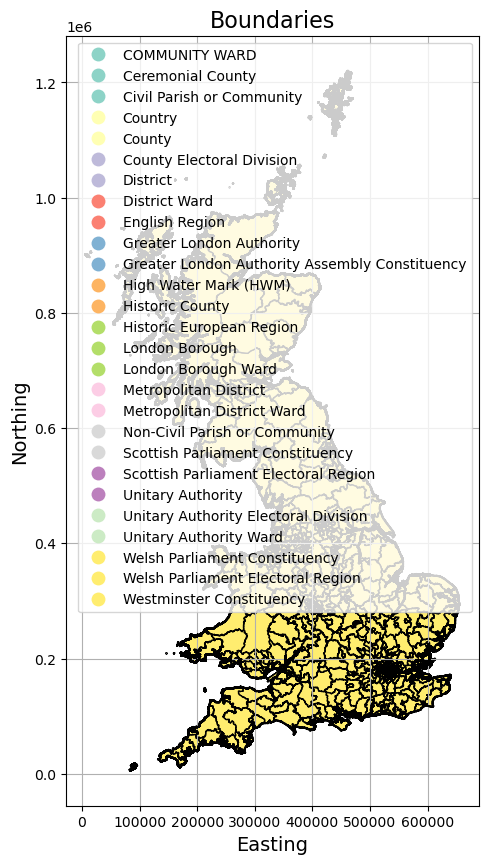

In [24]:
# Plot the GeoDataFrame with coloring based on the '_mode' column
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the basemap data, using '_mode' for coloring
admin_boundaries_gdf.plot(column='DESCRIPTIO', ax=ax, legend=True, edgecolor='black', cmap='Set3')

# Customize the plot
ax.set_title("Boundaries", fontsize=16)
ax.set_xlabel("Easting", fontsize=14)
ax.set_ylabel("Northing", fontsize=14)
ax.grid(True)

# Show the plot
plt.show()

## Data Cleaning

In [25]:
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon, MultiPolygon
from sklearn.neighbors import BallTree

##### Admin Boundaries

In [26]:
def process_admin_boundaries(admin_boundaries_gdf):
    # Drop columns with all NaN values
    admin_boundaries_gdf = admin_boundaries_gdf.dropna(axis=1, how='all')

    # Drop unnecessary columns (adjust this list based on your specific needs)
    columns_to_drop = ['FILE_NAME', 'NUMBER', 'NUMBER0', 'POLYGON_ID', 'UNIT_ID', 'LINK_ID', 'OBJECTID']
    admin_boundaries_gdf = admin_boundaries_gdf.drop(columns=columns_to_drop)

    # Fill NaN entries (adjust the fill method based on the nature of each column)
    fill_unknown_columns = ['NAME', 'DESCRIPTIO', 'AREA_CODE', 'CODE', 'TYPE_CODE', 'DESCRIPT0']
    for col in fill_unknown_columns:
        admin_boundaries_gdf[col] = admin_boundaries_gdf[col].fillna('Unknown')

    # For numeric columns, fill with the median
    numeric_columns = ['HECTARES', 'AREA']
    for col in numeric_columns:
        if col in admin_boundaries_gdf.columns:
            admin_boundaries_gdf[col] = admin_boundaries_gdf[col].fillna(admin_boundaries_gdf[col].median())

    # For the remaining columns, fill with 'Unknown' or another appropriate value
    remaining_columns = ['COMMUNITY', 'PD_ID', 'County', 'Distric_Bo', 'Ward', 'Parish']
    for col in remaining_columns:
        if col in admin_boundaries_gdf.columns:
            admin_boundaries_gdf[col] = admin_boundaries_gdf[col].fillna('Unknown')

    return admin_boundaries_gdf

In [27]:
# Process the administrative boundaries GeoDataFrame
admin_boundaries_gdf = process_admin_boundaries(admin_boundaries_gdf)

# Display information about the updated GeoDataFrame
admin_boundaries_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 100597 entries, 0 to 100596
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   NAME        100597 non-null  object  
 1   DESCRIPTIO  100597 non-null  object  
 2   geometry    100597 non-null  geometry
 3   COMMUNITY   100597 non-null  object  
 4   AREA_CODE   100597 non-null  object  
 5   CODE        100597 non-null  object  
 6   HECTARES    100597 non-null  float64 
 7   AREA        100597 non-null  float64 
 8   TYPE_CODE   100597 non-null  object  
 9   DESCRIPT0   100597 non-null  object  
 10  PD_ID       100597 non-null  object  
 11  County      100597 non-null  object  
 12  Distric_Bo  100597 non-null  object  
 13  Ward        100597 non-null  object  
 14  Parish      100597 non-null  object  
dtypes: float64(2), geometry(1), object(12)
memory usage: 11.5+ MB


In [41]:
admin_boundaries_gdf.geometry.type.value_counts()

Polygon         66041
LineString      34086
MultiPolygon      470
Name: count, dtype: int64

##### Point of Interest

##### Identify Reference Points for Cleaning: 
Dropping Unnecessary Columns: Removes columns not needed for processing.

Separating Rows with Null Values: Identifies rows with missing 'address_detail', 'street_name', or 'locality' values.

It identifies rows with null values in the address fields using a boolean mask.

It groups the data by admin_boundary and fills null values with the first non-null value in each group for each of the address columns

For any remaining null values, it groups by postcode and fills null values similarity

The transform method is used with fillna to perform forward and backward filling within each group detail

In [28]:
def drop_unnecessary_columns(poi_gdf):
    """
    Drop unnecessary columns from the POI GeoDataFrame.
    """
    columns_to_drop = [
        'uprn', 'telephone_number', 'url', 'brand', 'qualifier_type', 'qualifier_data', 
        'provenance', 'supply_date'
    ]
    return poi_gdf.drop(columns=columns_to_drop)

In [29]:
# Process the points of interest GeoDataFrame
poi_gdf = drop_unnecessary_columns(poi_gdf)

# Display information about the updated GeoDataFrame
poi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 385401 entries, 0 to 385400
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   ref_no             385401 non-null  int64   
 1   name               385401 non-null  object  
 2   pointx_class       385401 non-null  object  
 3   groupname          385401 non-null  object  
 4   categoryname       385401 non-null  object  
 5   classname          385401 non-null  object  
 6   feature_easting    385401 non-null  float64 
 7   feature_northing   385401 non-null  float64 
 8   pos_accuracy       385401 non-null  int64   
 9   topo_toid          385401 non-null  object  
 10  topo_toid_version  385401 non-null  int64   
 11  usrn               385401 non-null  object  
 12  usrn_mi            385401 non-null  int64   
 13  distance           385401 non-null  float64 
 14  address_detail     281731 non-null  object  
 15  street_name        280773 

In [30]:
def clean_address_details(poi_gdf):
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    poi_gdf = poi_gdf.copy()
    
    # Identify rows with null values in address fields
    null_mask = poi_gdf['address_detail'].isnull() | poi_gdf['street_name'].isnull() | poi_gdf['locality'].isnull()
    
    # Group by admin_boundary and fill null values with the first non-null value in each group
    for col in ['address_detail', 'street_name', 'locality']:
        poi_gdf.loc[null_mask, col] = poi_gdf.loc[null_mask].groupby('admin_boundary')[col].transform(lambda x: x.ffill().bfill())
    
    # For remaining nulls, group by postcode and fill
    null_mask = poi_gdf['address_detail'].isnull() | poi_gdf['street_name'].isnull() | poi_gdf['locality'].isnull()
    for col in ['address_detail', 'street_name', 'locality']:
        poi_gdf.loc[null_mask, col] = poi_gdf.loc[null_mask].groupby('postcode')[col].transform(lambda x: x.ffill().bfill())
    
    # Fill any remaining nulls with a default value
    poi_gdf['address_detail'].fillna('Unknown', inplace=True)
    poi_gdf['street_name'].fillna('Unknown', inplace=True)
    poi_gdf['locality'].fillna('Unknown', inplace=True)
    
    return poi_gdf

In [31]:
# Clean address details in poi_gdf
poi_gdf = clean_address_details(poi_gdf)

# Display cleaned GeoDataFrame info
poi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 385401 entries, 0 to 385400
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   ref_no             385401 non-null  int64   
 1   name               385401 non-null  object  
 2   pointx_class       385401 non-null  object  
 3   groupname          385401 non-null  object  
 4   categoryname       385401 non-null  object  
 5   classname          385401 non-null  object  
 6   feature_easting    385401 non-null  float64 
 7   feature_northing   385401 non-null  float64 
 8   pos_accuracy       385401 non-null  int64   
 9   topo_toid          385401 non-null  object  
 10  topo_toid_version  385401 non-null  int64   
 11  usrn               385401 non-null  object  
 12  usrn_mi            385401 non-null  int64   
 13  distance           385401 non-null  float64 
 14  address_detail     385401 non-null  object  
 15  street_name        385401 

In [32]:
poi_gdf.geometry.type.value_counts()

Point    385401
Name: count, dtype: int64

##### OS builtup Area

In [33]:
builtup_area_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8545 entries, 0 to 8544
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   gsscode          8545 non-null   object  
 1   name1_text       8545 non-null   object  
 2   name1_language   210 non-null    object  
 3   name2_text       222 non-null    object  
 4   name2_language   210 non-null    object  
 5   areahectares     8545 non-null   float64 
 6   geometry_area_m  8545 non-null   float64 
 7   geometry         8545 non-null   geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 534.2+ KB


In [34]:
# Columns to drop
builtup_to_drop = ['name1_language', 'name2_text', 'name2_language']

# Drop the columns
builtup_area_gdf = builtup_area_gdf.drop(columns=builtup_to_drop)

# Display cleaned DataFrame info
builtup_area_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8545 entries, 0 to 8544
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   gsscode          8545 non-null   object  
 1   name1_text       8545 non-null   object  
 2   areahectares     8545 non-null   float64 
 3   geometry_area_m  8545 non-null   float64 
 4   geometry         8545 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 333.9+ KB


In [35]:
builtup_area_gdf.geometry.type.value_counts()

MultiPolygon    8545
Name: count, dtype: int64

##### OS Open Roads

In [36]:
columns_to_keep = [
    'identifier', 'geometry', 'class', 'formOfWay', 'length', 
    'primary', 'trunkRoad', 'loop', 'startNode', 'endNode', 'function'
]

# Select only the columns to keep
open_road_gdf = open_road_gdf[columns_to_keep]

# Display the cleaned GeoDataFrame info
open_road_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1179499 entries, 0 to 1179498
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   identifier  1179499 non-null  object  
 1   geometry    1179499 non-null  geometry
 2   class       641526 non-null   object  
 3   formOfWay   641526 non-null   object  
 4   length      641526 non-null   float64 
 5   primary     641526 non-null   object  
 6   trunkRoad   641526 non-null   object  
 7   loop        641526 non-null   object  
 8   startNode   641526 non-null   object  
 9   endNode     641526 non-null   object  
 10  function    641526 non-null   object  
dtypes: float64(1), geometry(1), object(9)
memory usage: 99.0+ MB


In [37]:
def clean_open_road_data(open_road_gdf):
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    open_road_gdf = open_road_gdf.copy()
    
    # For categorical columns, fill nulls with 'Unknown'
    categorical_columns = ['class', 'formOfWay', 'primary', 'trunkRoad', 'loop', 'function']
    for col in categorical_columns:
        open_road_gdf[col].fillna('Unknown', inplace=True)
    
    # For 'length', fill nulls with the median value
    open_road_gdf['length'].fillna(open_road_gdf['length'].median(), inplace=True)
    
    # For 'startNode' and 'endNode', fill nulls with a placeholder
    open_road_gdf['startNode'].fillna('Node_Unknown', inplace=True)
    open_road_gdf['endNode'].fillna('Node_Unknown', inplace=True)
    
    # Handle any potential duplicates
    open_road_gdf.drop_duplicates(subset='identifier', keep='first', inplace=True)
    
    # Convert Point Z to Point (2D) and handle LineString geometries
    def convert_to_2d(geom):
        if geom.geom_type == 'Point' and geom.has_z:
            return Point(geom.x, geom.y)
        elif geom.geom_type == 'LineString' and geom.has_z:
            return LineString([(x, y) for x, y, z in geom.coords])
        return geom

    open_road_gdf['geometry'] = open_road_gdf['geometry'].apply(convert_to_2d)
    
    # Validate geometry
    # Remove any invalid geometries
    open_road_gdf = open_road_gdf[open_road_gdf.geometry.is_valid]
    
    return open_road_gdf

In [38]:
open_road_gdf = clean_open_road_data(open_road_gdf)

In [39]:
# Check the geometry types after cleaning
open_road_gdf.geometry.type.value_counts()

LineString    641296
Point         537972
Name: count, dtype: int64

In [40]:
# Display cleaned GeoDataFrame info
open_road_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1179268 entries, 0 to 1179498
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   identifier  1179268 non-null  object  
 1   geometry    1179268 non-null  geometry
 2   class       1179268 non-null  object  
 3   formOfWay   1179268 non-null  object  
 4   length      1179268 non-null  float64 
 5   primary     1179268 non-null  object  
 6   trunkRoad   1179268 non-null  object  
 7   loop        1179268 non-null  object  
 8   startNode   1179268 non-null  object  
 9   endNode     1179268 non-null  object  
 10  function    1179268 non-null  object  
dtypes: float64(1), geometry(1), object(9)
memory usage: 108.0+ MB


## DATA JOINING

#####  Create a grid covering the entire London area using the bounding box

In [75]:
# Create bounding box
london_bbox = box(-0.5103751, 51.2867601, 0.3340155, 51.6918741)

# Create a GeoDataFrame for the bounding box and set the CRS
london_bbox_gdf = gpd.GeoDataFrame({'geometry': [london_bbox]}, crs="EPSG:4326")

# Define the cell size (in degrees)
cell_size = 0.01

# Create a grid
minx, miny, maxx, maxy = london_bbox.bounds
x_coords = np.arange(minx, maxx, cell_size)
y_coords = np.arange(miny, maxy, cell_size)
grid_cells = [box(x, y, x + cell_size, y + cell_size) for x in x_coords for y in y_coords]
london_grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs="EPSG:4326")
london_grid['grid_id'] = london_grid.index

# Convert london_grid to EPSG:27700
london_grid = london_grid.to_crs("EPSG:27700")

##### Spatial Join and Aggregate Features

In [76]:
def spatial_join_and_aggregate(gdf, grid, feature_columns, agg_method='median'):
    # Ensure both geodataframes have the same CRS
    if gdf.crs != grid.crs:
        gdf = gdf.to_crs(grid.crs)
    
    joined = gpd.sjoin(grid, gdf, how='left', predicate='intersects')
    aggregated = joined.groupby('grid_id')[feature_columns].agg(agg_method).reset_index()
    return grid.merge(aggregated, on='grid_id', how='left')

# Admin boundaries
admin_features = ['HECTARES', 'AREA']
grid_with_admin = spatial_join_and_aggregate(admin_boundaries_gdf, london_grid, admin_features)

In [77]:
# Points of Interest (POI)
poi_features = ['pos_accuracy', 'distance']
grid_with_poi = spatial_join_and_aggregate(poi_gdf, london_grid, poi_features)

# Built-up area
builtup_features = ['areahectares', 'geometry_area_m']
grid_with_builtup = spatial_join_and_aggregate(builtup_area_gdf, london_grid, builtup_features)

# Open road
road_features = ['length']
grid_with_road = spatial_join_and_aggregate(open_road_gdf, london_grid, road_features)

# VML (Vector Map Local)
vml_features = ['FeatCode']
grid_with_vml = spatial_join_and_aggregate(vml_gdf, london_grid, vml_features)

In [ ]:
# Land use
def process_landuse(landuse_gdf, grid):
    if landuse_gdf.crs != grid.crs:
        landuse_gdf = landuse_gdf.to_crs(grid.crs)
    
    joined = gpd.sjoin(grid, landuse_gdf, how='left', predicate='intersects')
    landuse_proportions = joined.groupby(['grid_id', 'high_level']).size().unstack(fill_value=0)
    landuse_proportions = landuse_proportions.div(landuse_proportions.sum(axis=1), axis=0)
    return grid.merge(landuse_proportions, on='grid_id', how='left')

grid_with_landuse = process_landuse(landuse_gdf, london_grid)

In [ ]:
# Combine all features
final_grid = london_grid.copy()
final_grid = final_grid.merge(grid_with_admin, on='grid_id', how='left')
final_grid = final_grid.merge(grid_with_poi, on='grid_id', how='left')
final_grid = final_grid.merge(grid_with_builtup, on='grid_id', how='left')
final_grid = final_grid.merge(grid_with_road, on='grid_id', how='left')
final_grid = final_grid.merge(grid_with_vml, on='grid_id', how='left')
final_grid = final_grid.merge(grid_with_landuse, on='grid_id', how='left')

In [ ]:
# Save to GeoJSON file
final_gdf.to_file("urban_function_analysis_london.geojson", driver='GeoJSON')

# Display final grid GeoDataFrame
final_gdf.head()